In [97]:
import pandas as pd
from src.utils.path_converter import path_converter

In [98]:
# df = pd.read_csv(path_converter("/data/raw/sales_train.csv"), encoding="latin1")

In [99]:
# Load dữ liệu
df2 = pd.read_csv(path_converter("/data/raw/online_retail.csv"), encoding="latin1")

# Chuyển InvoiceDate sang datetime
df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)

# Thêm date_block_num theo tháng
df2["date_block_num"] = (df2["InvoiceDate"].dt.year - 2010) * 12 + (
    df2["InvoiceDate"].dt.month - 1
)

# Nếu chỉ có 1 shop: tạo shop_id = 0
df2["shop_id"] = 0

# Map StockCode thành item_id
df2["item_id"] = df2["StockCode"].astype("category").cat.codes

# Group theo ngày + item + shop
df2_new = (
    df2.groupby(["InvoiceDate", "date_block_num", "shop_id", "item_id"])
    .agg(
        {"UnitPrice": "mean", "Quantity": "sum"}  # trung bình nếu nhiều đơn trong ngày
    )
    .reset_index()
)

# Đổi tên cột và chuyển date về format DD.MM.YYYY
df2_new.rename(
    columns={
        "InvoiceDate": "date",
        "UnitPrice": "item_price",
        "Quantity": "item_cnt_day",
    },
    inplace=True,
)

df2_new["date"] = df2_new["date"].dt.strftime("%d.%m.%Y")

df = df2_new.copy()

print(df2_new.head())

/var/folders/x8/3s0s9pbj7bgb2h7w5bbd8v7h0000gn/T/ipykernel_67863/384556747.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  12.01.2010               0        0      800        4.25             6
1  12.01.2010               0        0     1662        7.65             2
2  12.01.2010               0        0     2794        3.39             6
3  12.01.2010               0        0     2984        3.39             6
4  12.01.2010               0        0     2985        3.39             6


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [136]:
# Tiền sử lý dữ liệu

In [137]:
# lọc sản phẩm trả hàng, giữ lại sản phẩm được bán

sold = df[df['item_cnt_day'] >= 0]


ta thấy block nào cũng đủ date trong tháng -> có thể tính tổng days = nunique cột date

In [138]:
total_days_of_selling = sold['date'].nunique()

print(total_days_of_selling)

305


In [142]:
demand_days = df['date'].groupby(sold['item_id']).nunique()

zero_demand_days = total_days_of_selling - demand_days

zero_ratio = zero_demand_days / total_days_of_selling

print(zero_demand_days)
print(zero_ratio.describe().round(2))

item_id
0.0       258
1.0       283
2.0       281
3.0       302
5.0       300
         ... 
4065.0    295
4066.0    298
4067.0    302
4068.0    301
4069.0    304
Name: date, Length: 3940, dtype: int64
count    3940.00
mean        0.77
std         0.22
min         0.00
25%         0.65
50%         0.84
75%         0.95
max         1.00
Name: date, dtype: float64


đếm tổng string khác nhau của 1 loại item => số ngày mà sản phẩm đó được bán

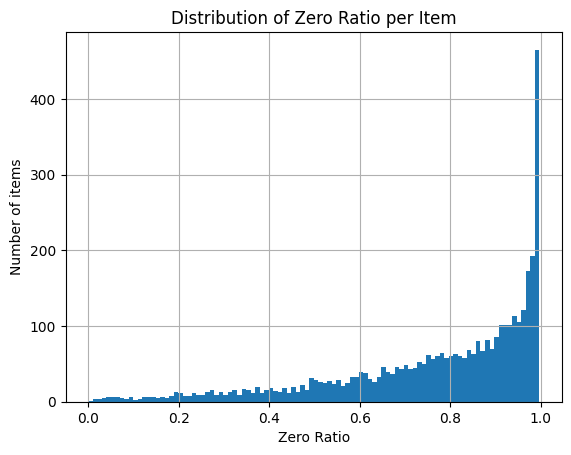

count    3940.000000
mean        0.769630
std         0.224649
min         0.000000
25%         0.652459
50%         0.839344
75%         0.950820
max         0.996721
Name: date, dtype: float64


In [144]:
zero_ratio.hist(bins=100)
plt.xlabel('Zero Ratio')
plt.ylabel('Number of items')
plt.title('Distribution of Zero Ratio per Item')
plt.show()
print(zero_ratio.describe())

In [111]:
day_sell_of_item = df['date'].groupby(sold['item_id']).unique()

In [112]:
items_df = pd.concat([zero_ratio, day_sell_of_item], axis=1)
items_df.columns = ['zero_ratio', 'days_sold']
print(items_df)

         zero_ratio                                          days_sold
item_id                                                               
0.0        0.845902  [12.01.2010, 12.02.2010, 12.03.2010, 12.05.201...
1.0        0.927869  [08.01.2011, 08.02.2011, 11.02.2011, 27.02.201...
2.0        0.921311  [12.03.2010, 12.08.2010, 12.10.2010, 08.02.201...
3.0        0.990164               [12.03.2010, 31.03.2011, 03.04.2011]
5.0        0.983607  [12.06.2010, 17.03.2011, 27.03.2011, 11.06.201...
...             ...                                                ...
4065.0     0.967213  [13.01.2011, 15.02.2011, 08.04.2011, 18.04.201...
4066.0     0.977049  [09.02.2011, 17.02.2011, 18.02.2011, 01.05.201...
4067.0     0.990164               [20.12.2010, 04.04.2011, 27.07.2011]
4068.0     0.986885   [23.12.2010, 05.06.2011, 24.06.2011, 30.06.2011]
4069.0     0.996721                                       [21.12.2010]

[3940 rows x 2 columns]


In [145]:
from src.utils.date_caculator import compute_interarrival
items_df['interarrival'] = items_df['days_sold'].map(compute_interarrival)


In [114]:
items_df['var_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).var()
items_df['mean_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).mean()
items_df['cv2'] = items_df['var_demand_days'] / (items_df['mean_demand_days'] ** 2)


In [115]:
items_df['ADI'] = items_df['interarrival'].apply(np.mean)

print(items_df['ADI'].describe())

count    3781.000000
mean       24.102703
std        40.360135
min         1.000000
25%         5.117647
50%         9.957143
75%        24.892857
max       565.000000
Name: ADI, dtype: float64


/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



In [116]:
q3_adi = items_df["ADI"].quantile(0)
q3_zero_ratio = items_df["zero_ratio"].quantile(0)
q3_cv2 = items_df["cv2"].quantile(0)


filter_items = items_df


print(filter_items.describe())

        zero_ratio  var_demand_days  mean_demand_days          cv2  \
count  3940.000000     3.788000e+03       3940.000000  3788.000000   
mean      0.769630     8.560512e+03         29.691567     3.483736   
std       0.224649     3.710819e+05       1290.464394     7.394929   
min       0.000000     0.000000e+00          1.000000     0.000000   
25%       0.652459     8.333333e+00          2.674731     0.773619   
50%       0.839344     6.377586e+01          5.499554     1.714734   
75%       0.950820     3.518728e+02         10.368421     3.789160   
max       0.996721     2.229064e+07      80995.000000   223.336547   

               ADI  
count  3781.000000  
mean     24.102703  
std      40.360135  
min       1.000000  
25%       5.117647  
50%       9.957143  
75%      24.892857  
max     565.000000  


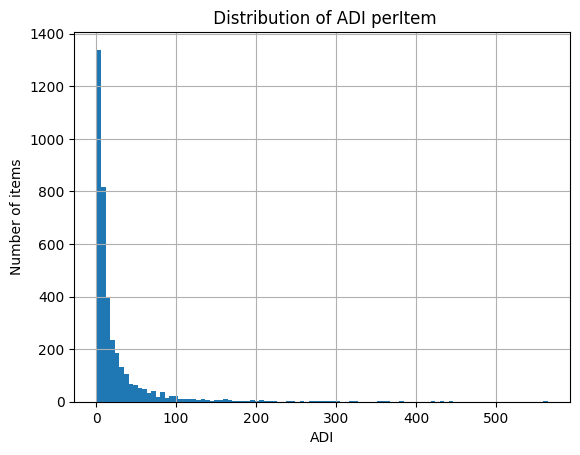

In [117]:
items_df['ADI'].hist(bins=100)
plt.xlabel('ADI')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()


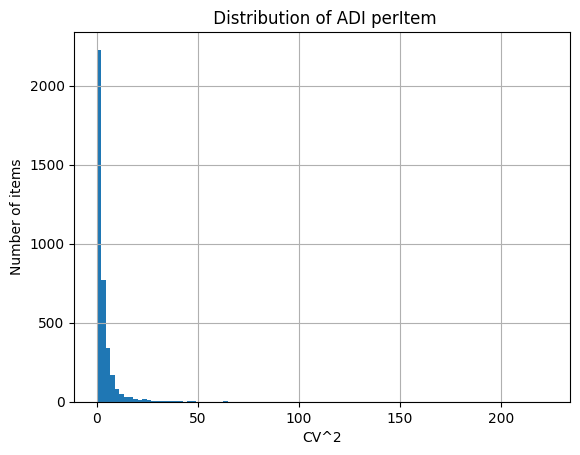

In [146]:
items_df['cv2'].hist(bins=100)
plt.xlabel('CV^2')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()


In [148]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


numeric_cols = ["cv2", "ADI", "zero_ratio"]
clean_df = remove_outliers_iqr(items_df, numeric_cols)

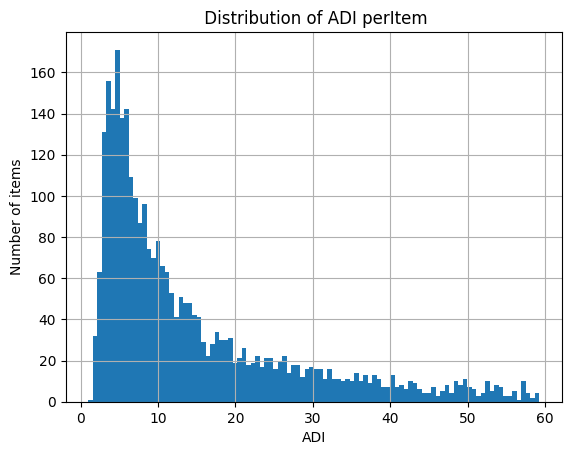

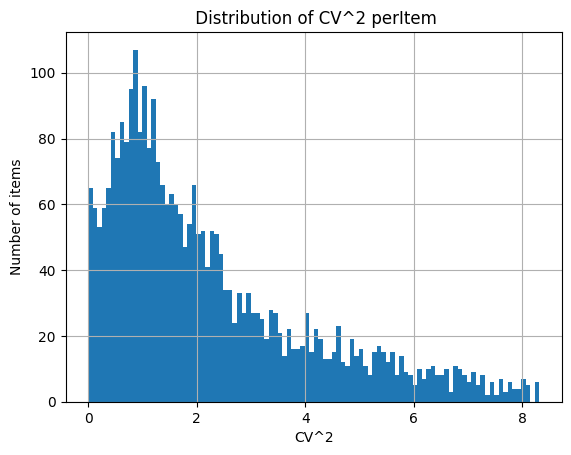

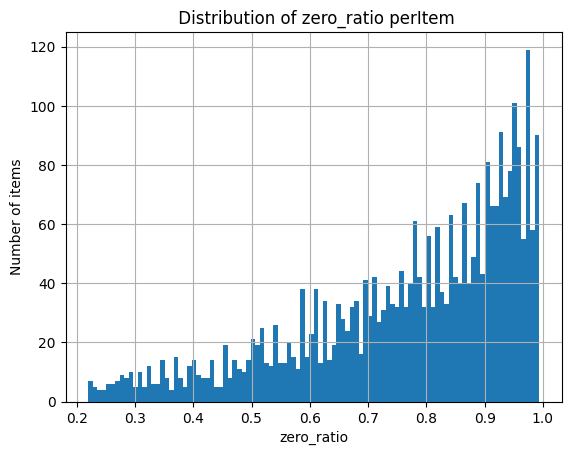

In [ ]:
clean_df['ADI'].hist(bins=100)
plt.xlabel('ADI')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()

clean_df['cv2'].hist(bins=100)
plt.xlabel('CV^2')
plt.ylabel('Number of items')
plt.title(' Distribution of CV^2 perItem')
plt.show()

clean_df['zero_ratio'].hist(bins=100)
plt.xlabel('zero_ratio')
plt.ylabel('Number of items')
plt.title(' Distribution of zero_ratio perItem')
plt.show()

In [161]:
import plotly.express as px

fig = px.scatter_matrix(
    clean_df,
    dimensions=["ADI", "cv2", "zero_ratio"],
    title="Interactive Pair Plot for Intermittent Demand",
    labels={"ADI": "ADI", "cv2": "CV²", "zero_ratio": "Zero Ratio"},
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")
fig.show()

In [162]:
from src.notebooks.const import name_mapping

df_visual = clean_df[["ADI", "cv2", "zero_ratio"]].dropna().copy()


def label_demand(row, coe_adi=1.32, coe_cv2=0.49, coe_zero_ratio=0.6):
    # Nếu ADI cao hoặc zero_ratio lớn → Intermittent/Lumpy (Gián đoạn)
    if row["ADI"] > coe_adi or row["zero_ratio"] >= coe_zero_ratio:
        # Nếu CV² thấp → Intermittent (Gián đoạn & Ổn định)
        if row["cv2"] < coe_cv2:
            return 2  # Intermittent
        else:
            return 0  # Lumpy (Gián đoạn & Biến động)
    else:
        # Nếu ADI thấp và zero_ratio nhỏ → Smooth/Erratic (Thường xuyên)
        # Bất kể CV² cao hay thấp, trường hợp này đều được gán là Smooth
        return 1  # Smooth (Bao gồm cả Smooth và Erratic)


df_visual["demand_type"] = df_visual.apply(
    lambda x: label_demand(
        x,
        coe_adi=df_visual["ADI"].mean(),
        coe_cv2=df_visual["cv2"].mean(),
        coe_zero_ratio=df_visual["zero_ratio"].mean(),
    ),
    axis=1,
)

In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ============================================
# 1) CHUẨN HÓA DỮ LIỆU CHO DBSCAN
# ============================================
X = df_visual[["ADI", "cv2", "zero_ratio"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================
# 2) CHẠY DBSCAN
# eps và min_samples có thể tune, đây là giá trị cơ bản
# eps nhỏ để không bị gom lung tung
# ============================================
dbscan = DBSCAN(
    eps=0.5,       # bạn có thể thử: 0.3 → 0.8
    min_samples=10 # giảm xuống 5 nếu dữ liệu ít
)
clusters = dbscan.fit_predict(X_scaled)

# ============================================
# 3) THÊM CỘT CLUSTER VÀO df_visual
# ============================================
df_visual["demand_type_dbscan"] = clusters


In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

# ============================================
# 1) CHUẨN HÓA DỮ LIỆU
# ============================================
X = df_visual[["ADI", "cv2", "zero_ratio"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================
# 2) TỰ ƯỚC LƯỢNG BANDWIDTH
# quantile = 0.2 → cụm nhiều hơn
# quantile = 0.3–0.4 → cụm ít lại
# ============================================
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)

meanshift = MeanShift(
    bandwidth=bandwidth,
    bin_seeding=True
)

# ============================================
# 3) FIT & GÁN CLUSTER
# ============================================
clusters = meanshift.fit_predict(X_scaled)

df_visual["demand_type_2"] = clusters


In [174]:
items_df.to_csv(
    path_converter("/data/processed/items_zero_ratio_days_sold.csv"), index=True
)
df_visual.to_csv(path_converter("/data/features/demand_type.csv"), index=True)

14.597066324427876
2.2425766860251604
0.7686382015558388


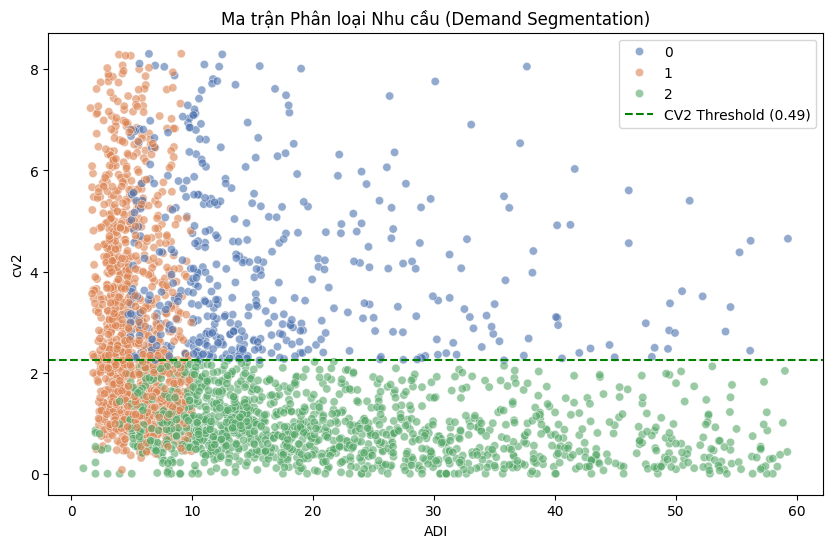

In [175]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_visual, x="ADI", y="cv2", hue="demand_type", alpha=0.6, palette="deep"
)

print(df_visual["ADI"].mean())
print(df_visual["cv2"].mean())
print(df_visual["zero_ratio"].mean())
plt.axhline(
    y=df_visual["cv2"].mean(),
    color="green",
    linestyle="--",
    label="CV2 Threshold (0.49)",
)
plt.title("Ma trận Phân loại Nhu cầu (Demand Segmentation)")
plt.legend()
plt.show()

In [177]:
fig = px.scatter_matrix(
    df_visual,
    # Liệt kê các cột muốn so sánh cặp
    dimensions=["ADI", "cv2", "zero_ratio"],
    color="demand_type",
    title="Interactive Pair Plot for Intermittent Demand",
    labels={
        "ADI": "ADI",
        "cv2": "CV²",
        "zero_ratio": "Zero Ratio",
        "demand_type": "Demand Type",
    },
)

# Tinh chỉnh marker như yêu cầu cũ
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")
print(name_mapping)
fig.show()

{0: 'Lumpy', 1: 'Smooth', 2: 'Intermittent'}


In [178]:
fig = px.scatter_matrix(
    df_visual,
    # Liệt kê các cột muốn so sánh cặp
    dimensions=["ADI", "cv2", "zero_ratio"],
    color="demand_type_dbscan",
    title="Interactive Pair Plot for Intermittent Demand",
    labels={
        "ADI": "ADI",
        "cv2": "CV²",
        "zero_ratio": "Zero Ratio",
        "demand_type_dbscan": "Demand Type",
    },
)

# Tinh chỉnh marker như yêu cầu cũ
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")
print(name_mapping)
fig.show()

{0: 'Lumpy', 1: 'Smooth', 2: 'Intermittent'}


In [179]:
fig = px.scatter_matrix(
    df_visual,
    # Liệt kê các cột muốn so sánh cặp
    dimensions=["ADI", "cv2", "zero_ratio"],
    color="demand_type_2",
    title="Interactive Pair Plot for Intermittent Demand",
    labels={
        "ADI": "ADI",
        "cv2": "CV²",
        "zero_ratio": "Zero Ratio",
        "demand_type_2": "Demand Type",
    },
)

# Tinh chỉnh marker như yêu cầu cũ
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")
print(name_mapping)
fig.show()

{0: 'Lumpy', 1: 'Smooth', 2: 'Intermittent'}
